# Burgan Bank Tweet Analysis

#### Import Libraries

In [34]:
import warnings
def warn(*args, **kwargs):
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    pass
warnings.warn = warn

In [35]:
import numpy as np
import pandas as pd
import re, random, os
import spacy
import string, pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim

In [37]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#### Import dataset containing tweets

In [38]:
tweet=pd.read_csv('BurganBankGroup_tweets.csv',encoding='ASCII')

#### Convert data from object type to string type

In [39]:
tweet.text=tweet.text.astype('str')

In [40]:
tweet.head()

,id,created_at,text
0,1294358298498564096,2020-08-14 19:40:41,b'#BurganBank\n#BurganTips https://t.co/2ELGNX...
1,1294203395507658752,2020-08-14 09:25:09,b'#BurganBank\n#BurganTips\n#CoronaTips https:...
2,1293977600713515015,2020-08-13 18:27:55,b'\xd9\x88\xd8\xb6\xd8\xb9 \xd9\x8a\xd9\x88\xd...
3,1293908033492226054,2020-08-13 13:51:29,b'\xd8\xa8\xd8\xae\xd8\xa7\xd8\xb7\xd8\xb1\xd9...
4,1293846145853263872,2020-08-13 09:45:34,b'#BurganBank\n#BurganTips\n#CoronaTips https:...


#### Count the number of tweets being analyzed

In [41]:
len(tweet.index)

3243

#### Check one of the tweets and its format imported

In [42]:
tweet.text[0]

"b'#BurganBank\\n#BurganTips https://t.co/2ELGNXmpoN'"

#### Remove first 2 and last characters which are "b'" and "'" in every tweet

In [43]:
tweet.text=tweet.text.apply(lambda x : x[2:])
tweet.text=tweet.text.apply(lambda x : x[:-1])

In [44]:
tweet.text[3]

'\\xd8\\xa8\\xd8\\xae\\xd8\\xa7\\xd8\\xb7\\xd8\\xb1\\xd9\\x83 \\xd8\\xaa\\xd9\\x84\\xd9\\x81\\xd8\\xb2\\xd9\\x8a\\xd9\\x88\\xd9\\x86\\xd8\\x9f \\xd8\\xa7\\xd8\\xb4\\xd8\\xaa\\xd8\\xb1 \\xd8\\xa3\\xd9\\x81\\xd8\\xb6\\xd9\\x84 \\xd8\\xa7\\xd9\\x84\\xd8\\xa3\\xd8\\xac\\xd9\\x87\\xd8\\xb2\\xd8\\xa9 \\xd8\\xa8\\xd8\\xa3\\xd8\\xb3\\xd8\\xb9\\xd8\\xa7\\xd8\\xb1 \\xd9\\x85\\xd8\\xb0\\xd9\\x87\\xd9\\x84\\xd8\\xa9 \\xd8\\xad\\xd8\\xb5\\xd8\\xb1\\xd9\\x8a\\xd8\\xa7\\xd9\\x8b \\xd9\\x84\\xd8\\xb9\\xd9\\x85\\xd9\\x84\\xd8\\xa7\\xd8\\xa1 \\xd8\\xa8\\xd8\\xb1\\xd9\\x82\\xd8\\xa7\\xd9\\x86 \\xd9\\x85\\xd9\\x86 \\xd8\\xae\\xd9\\x84\\xd8\\xa7\\xd9\\x84 \\xd8\\xa7\\xd9\\x84\\xd9\\x85\\xd9\\x88\\xd9\\x82\\xd8\\xb9 \\xd9\\x81\\xd9\\x8a \\xd8\\xa7\\xd9\\x84\\xd8\\xa8\\xd8\\xa7\\xd9\\x8a\\xd9\\x88.\\n\\n#BurganBank\\xe2\\x80\\xa6 https://t.co/NjUHdWHArz'

In [45]:
tweet.created_at=tweet.created_at.apply(lambda x : x[:10])

In [46]:
tweet.created_at=tweet.created_at.apply(lambda x : x.replace('-',''))
tweet.created_at.head()

0    20200814
1    20200814
2    20200813
3    20200813
4    20200813
Name: created_at, dtype: object

In [47]:
tweet.created_at=tweet.created_at.astype('int')

In [48]:
tweet_dates=pd.DataFrame(tweet.created_at.unique())

In [49]:
tweet_dates=tweet_dates.drop_duplicates()

In [50]:
tweet_dates.sort_values(0)

,0
1198,20170317
1197,20170318
1196,20170319
1195,20170320
1194,20170321
...,...
4,20200810
3,20200811
2,20200812
1,20200813


#### Clean the data to reduce the irrelavant text

##### Replace unique and non text characters to get proper and meaningful data

In [51]:
def replace_str(i,j):
    tweet.text=tweet.text.apply(lambda x : x.replace(i,j))

In [52]:
def replaced(l):
    for k in l:
        replace_str(k,' ')
        
def replaced_nc(p):
    for k in p:
        replace_str(k,' ')

In [53]:
tweet.text=tweet.text.apply(lambda x : x.encode('ascii',errors='ignore').decode())

In [54]:
lst=['\n','\x80','\x81','\x82','\x83','\x84','\x85','\x86','\x87','\x88','\x89','\xa0','\xa1','\xa2','\xa3','\xa4','\xa5','\xa6','\xa7','\xa8','\xa9',
'\xab','\xaa','\xac','\xad','\xae','\xaf','\xb2','\xb1','\xb3','\xb4','\xb6','\xb5','\xb7','\xb9','\xd8','\xe2','\\n','\\x80','\\x81','\\x82','\\x83',
'\\x84','\\x85','\\x86','\\x87','\\x88','\\x89','\\xa0','\\xa1','\\xa2','\\xa3','\\xa4','\\xa5','\\xa6','\\xa7','\\xa8','\\xa9','\\xab','\\xaa','\\xac',
'\\xad','\\xae','\\xaf','\\xb2','\\xb1','\\xb3','\\xb4','\\xb6','\\xb5','\\xb7','\\xb9','\\xd8','\\xe2','\\xd9','\\x8a']

In [55]:
nc=['-','_','@','#','\n','\t','.','*','!','$','%','(',')','[',']','{','}',',','|','https://','http://','co',':','/','\'','\"']

In [56]:
replaced(lst)
replaced_nc(nc)

In [57]:
tweet.text.head()

0               BurganBank  BurganTips  t   2ELGNXmpoN
1     BurganBank  BurganTips  CoronaTips  t   YnHGR...
2                                                     
3                                \x9f              ...
4     BurganBank  BurganTips  CoronaTips  t   28tSg...
Name: text, dtype: object

#### Convert each sentence to a list of words

In [58]:
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  

In [59]:
data = tweet.text.values.tolist()

In [60]:
data[:5]

[' BurganBank  BurganTips  t   2ELGNXmpoN',
 ' BurganBank  BurganTips  CoronaTips  t   YnHGRbWZG5',
 '                              ',
 '                            \\x9f                                                  \\xb0                  \\x8b                                                                         BurganBank     t   NjUHdWHArz',
 ' BurganBank  BurganTips  CoronaTips  t   28tSgXdKzK']

#### Below is the list of words we got from each tweet

In [61]:
data_words = list(sent_to_words(data))
print(data_words[3])

['xb', 'burganbank', 'njuhdwharz']


#### Remove grammer and highly repetitive to get words which make the data useful

In [62]:
stop_words = stopwords.words('english') + list(string.punctuation)

In [63]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data_words_nostops = remove_stopwords(data_words)

#### Do lemmatization and stemming to reduce words to their base form

In [64]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [65]:
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [66]:
print(data_lemmatized[0])

['burganbank', 'burgantip', 'elgnxmpon']


In [67]:
id2word = corpora.Dictionary(data_lemmatized)

In [68]:
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
print(corpus[2])

[]


In [69]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('burganbank', 1), ('burgantip', 1), ('elgnxmpon', 1)]]

#### Create topics to know what the tweets are about

In [70]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=300,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### Check the weightage of words in each topic

In [71]:
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"xf" + 0.018*"burganbank" + 0.017*"tip" + 0.015*"burganbanktip" + '
  '0.014*"banking" + 0.013*"xba" + 0.013*"travel" + 0.013*"service" + '
  '0.010*"mention" + 0.008*"day"'),
 (1,
  '0.208*"xdb" + 0.044*"unt" + 0.025*"burganbank" + 0.023*"kd" + '
  '0.022*"kuwait" + 0.018*"dis" + 0.014*"ac" + 0.013*"burganbankyawmi" + '
  '0.013*"get" + 0.012*"enjoy"'),
 (2,
  '0.047*"burganoffer" + 0.028*"burganbank" + 0.009*"zayonal" + 0.007*"aljohy" '
  '+ 0.005*"burganbankcard" + 0.005*"lose" + 0.005*"csmurfs" + 0.004*"use" + '
  '0.004*"hand" + 0.004*"aia"'),
 (3,
  '0.063*"bank" + 0.059*"burgan" + 0.049*"xc" + 0.042*"xb" + 0.036*"yawmi" + '
  '0.036*"winner" + 0.036*"congratulation" + 0.031*"youth" + 0.020*"draw" + '
  '0.016*"lucky"'),
 (4,
  '0.030*"step" + 0.026*"regard" + 0.026*"cbk" + 0.025*"file" + '
  '0.025*"mplaint" + 0.022*"burganbankdraw" + 0.017*"regulate" + '
  '0.015*"change" + 0.012*"know" + 0.009*"burganbank"')]


#### Check the coherence or relavancy score, where score above 0.4 is good

In [72]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5541613322352947


#### Visualize the topics in word frequency distribution

In [73]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.110758 -0.217860       1        1  27.363024
3     -0.264554 -0.041206       2        1  24.865765
0      0.042796  0.072812       3        1  16.999937
2      0.070084  0.085434       4        1  16.644711
4      0.040916  0.100821       5        1  14.126571, topic_info=             Term        Freq       Total Category  logprob  loglift
110           xdb  790.000000  790.000000  Default  30.0000  30.0000
36           bank  217.000000  217.000000  Default  29.0000  29.0000
38         burgan  204.000000  204.000000  Default  28.0000  28.0000
5048           xc  169.000000  169.000000  Default  27.0000  27.0000
20            unt  166.000000  166.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1682         send    5.420107    6.126931   Topic5  -5.8887   1.8345
1187  burganyouth    5.370067    6.085059   Topic5  -5.8980   1.8321
1603      sponsor    6.525214    7.595596   Topic5  -5.7032   1.8052
5053   jfpjzyzkgu    5.976356    6.907158   Topic5  -5.7910   1.8124
0      burganbank   18.415758  219.142395   Topic5  -4.6657  -0.5194

[192 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1059      1  0.989089       ac
4228      4  0.966265      aia
45        2  0.978220  airport
582       2  0.935509      ali
5119      4  0.980916   aljohy
...     ...       ...      ...
43        2  0.995217    yawmi
701       5  0.963958     year
146       2  0.996548    youth
4985      4  0.969427  zayonal
2966      4  0.898805       zw

[167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5])

**Observations:**

#### Name the topics with words that are frequently seen
##### Topic1-Promotional offers    (words : winner, lucky, draw, cinema, grand, congratulation, prize, hurry)
##### Topic2-Credit Card                (words : call, credit, card, enjoy, offer, mastercard, free, hotel, qatar)
##### Topic3-Job Opportunity       (words : service, opportunity, announce, package, recruitment, marketing)
##### Topic4-Banking Benefits     (words : win, stay, iphone, chance, family, allowance, educational, kid)
##### Topic5-Anonymous             (words : branch, open, october, first, jan, location, ramadan, operation)

In [74]:
tweet.text.head()

0               BurganBank  BurganTips  t   2ELGNXmpoN
1     BurganBank  BurganTips  CoronaTips  t   YnHGR...
2                                                     
3                                \x9f              ...
4     BurganBank  BurganTips  CoronaTips  t   28tSg...
Name: text, dtype: object

In [75]:
word_dist=pd.DataFrame(pd.Series(' '.join(tweet.text).split()).value_counts()).reset_index(drop=False)

In [76]:
word_dist=word_dist.rename(columns={'index':'word',0:'freq'})

In [77]:
word_dist.head()

,word,freq
0,t,2699
1,\xdb\x8c,911
2,\x8c,671
3,BurganBank,614
4,\xb0,480


In [78]:
wldf_exc_list=['Winner',
'Lucky',
'Congratulations',
'Prize',
'Hurry',
'Credit',
'Card',
'Enjoy',
'Mastercard',
'Hotel',
'Opportunity',
'Recruitment',
'Package',
'Service',
'Marketing',
'Win',
'Iphone',
'Family',
'Children',
'Education',
'Branch',
'Open',
'Location',
'Operation',
'Ramdan']

In [79]:
wldf_exc_list = [element.lower() for element in wldf_exc_list]

In [80]:
wldf_exc_list

['winner',
 'lucky',
 'congratulations',
 'prize',
 'hurry',
 'credit',
 'card',
 'enjoy',
 'mastercard',
 'hotel',
 'opportunity',
 'recruitment',
 'package',
 'service',
 'marketing',
 'win',
 'iphone',
 'family',
 'children',
 'education',
 'branch',
 'open',
 'location',
 'operation',
 'ramdan']

In [81]:
word_dist=word_dist[word_dist.word.isin(wldf_exc_list)].reset_index(drop=True)

In [82]:
word_dist

,word,freq
0,card,70
1,enjoy,46
2,service,39
3,branch,25
4,credit,21
5,win,20
6,winner,18
7,lucky,18
8,prize,9
9,open,8


In [83]:
word_dist.to_excel('Word_Dist_Tweet.xlsx')

In [84]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [85]:
string=tweet.text.str.cat(sep=' ')

In [86]:
string=re.sub("\\\\","",string)

In [87]:
string=string.replace('  ',' ')
string=string.replace('  ',' ')
string=string.replace('  ',' ')
string=string.replace('  ',' ')
string=string.replace('  ',' ')

In [88]:
string=string.replace('xdbx8c',' ')
string=string.replace('x8c',' ')
string=string.replace('x9f',' ')
string=string.replace('x8b',' ')
string=string.replace('78o8e',' ')

In [89]:
string

' BurganBank BurganTips t 2ELGNXmpoN BurganBank BurganTips CoronaTips t YnHGRbWZG5     xb0     BurganBank t NjUHdWHArz BurganBank BurganTips CoronaTips t 28tSgXdKzK BurganBank BurganServices t vmlMps9Wvr xb0    t 44C2PWRCD8 To benefit from this offer please register t 9QIqduXqM3 10 x91 theathletesfootkuwait Enjoy a 10 dis unt from theathletesfootkuwait BurganOffers t jx6VDsoV2T  burganbank t zWXxToVSTi BurganBank BurganTips CoronaTips t llB4KWDdny x9cBANKI x9d xb0     The x9cBANKI x9d inter t S53JPiILsd  BurganBank t 8Gf2nNWe0X         t 5auV36c0y3 hala92     1804080  1804080 BurganBank BurganServices t nz7FlF0LX7 BurganBank BurganTips TravelTips t xiUSSCjp4h   Congratulations to all the winners in Yawmi draw with Burgan Bank t Im78hRnKqH Burgan Bank VISA Platinum Credit Card offers you the below benefits Unlimited access to access to 25 airport lo t qxKoWMeVnB xb0    1804080 We will ntinue serving our customers throug t Lu3NuD75r7        xb0 t zYYGzWabt5        xb0 xb0    be t rmQ63a6

In [90]:
#Word cloud Distribution
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=5 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.savefig('word_cloud.png')
    plt.show()

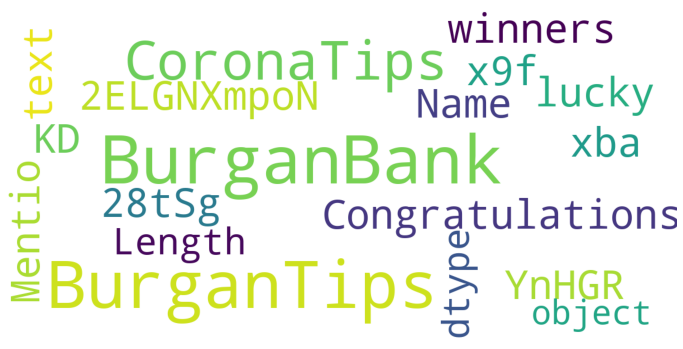

In [91]:
show_wordcloud(tweet.text)